In [ ]:
# The program requires "all_data.csv" in the same directory to function properly.
# It applies machine learning algorithms to the dataset and evaluates their performance.
# Algorithms used: Naïve Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors.
# Output includes: file name, algorithm name, accuracy, precision, recall, F1-score, and execution time.
# The program generates a CSV file with results and a folder with graphical representations.

In [ ]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Intrusion Detection System/"

Mounted at /content/drive


In [ ]:
# Define directories and files
result = os.path.join(base_path, "results", "results_2.csv")  # CSV file to save results
csv_files = ["all_data.csv"]  # Data file
data_file = os.path.join(base_path, "all_data.csv")  # assuming the file is in the base folder
repetition = 10

def folder(f_name):
    # Create a folder if it does not exist.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

In [ ]:
# Create results and graph folders if they don't exist
results_folder = os.path.join(base_path, "results")
graph_folder = os.path.join(results_folder, "result_graph_2")
folder(results_folder)
folder(graph_folder)

In [ ]:
# Define the machine learning algorithms to be used
ml_list = {
    "Naive Bayes": GaussianNB(),
    "QDA": QDA(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy"),
    "AdaBoost": AdaBoostClassifier(),
    "MLP": MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500),
    "Nearest Neighbors": KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='manhattan')
}

# Define the features to be used (list of 18 features as specified)
features = {
    "all_data": ["Bwd Packet Length Max", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s",
                 "Flow Duration", "Flow IAT Max", "Flow IAT Mean", "Flow IAT Min", "Flow IAT Std", "Fwd IAT Total",
                 "Fwd Packet Length Max", "Fwd Packet Length Mean", "Fwd Packet Length Min", "Fwd Packet Length Std",
                 "Total Backward Packets", "Total Fwd Packets", "Total Length of Bwd Packets", "Total Length of Fwd Packets",
                 "Label"]
}

In [ ]:
seconds = time.time()  # Start timer

# Create CSV file to save the results
with open(result, "w", newline="", encoding="utf-8") as f:
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.78            0.63            0.64            0.63            2.6883         
all_data          QDA                0.31            0.58            0.58            0.31            6.128          
all_data          Random Forest      0.94            0.97            0.83            0.88            15.6351        
all_data          ID3                0.95            0.97            0.86            0.9             21.8445        
all_data          AdaBoost           0.94            0.94            0.84            0.88            244.6342       
all_data          MLP                0.84            0.74            0.54            0.53            237.7387       
all_data          Nearest Neighbors  0.97            0.94            0.95            0.95            1287.5875      


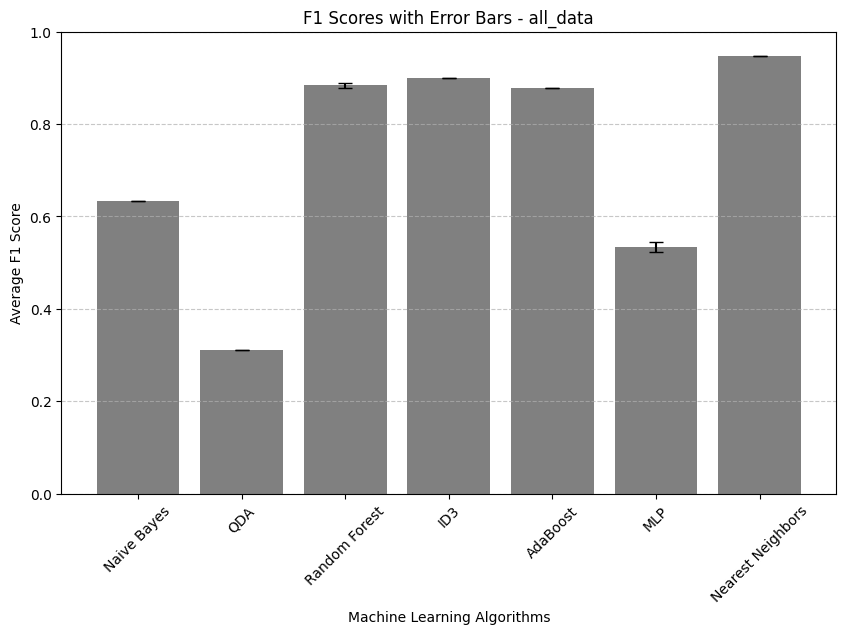

Total operation time: =  18209.91541171074 seconds


In [ ]:
# Process each file in the csv_files list
for j in csv_files:
    print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' %
          ("File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"))

    # Read data using the defined features for "all_data"
    feature_list = list(features[j[0:-4]])
    df = pd.read_csv(data_file, usecols=feature_list)
    df = df.fillna(0)

    # Convert labels: 'BENIGN' to 1 and any attack label to 0
    attack_or_not = []
    for i in df["Label"]:
        if i == "BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)
    df["Label"] = attack_or_not

    # Separate labels and features
    y = df["Label"]
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    # To store aggregated F1 mean and std for each algorithm (for combined bar chart)
    ml_names = []
    f1_means = []
    f1_stds = []

    # Process each ML algorithm
    for algo in ml_list:
        precision_list = []
        recall_list = []
        f1_list = []
        accuracy_list = []
        t_time_list = []
        for i in range(repetition):
            start_time = time.time()
            # Split the data for cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=repetition)

            # Train and predict
            clf = ml_list[algo]
            clf.fit(X_train, y_train)
            predict = clf.predict(X_test)

            # Calculate performance metrics
            f_1 = f1_score(y_test, predict, average='macro')
            pr = precision_score(y_test, predict, average='macro')
            rc = recall_score(y_test, predict, average='macro')

            precision_list.append(float(pr))
            recall_list.append(float(rc))
            f1_list.append(float(f_1))
            accuracy_list.append(clf.score(X_test, y_test))
            t_time_list.append(time.time() - start_time)

        # Print average performance for the current algorithm
        print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' %
              (j[0:-4], algo, str(round(np.mean(accuracy_list), 2)),
               str(round(np.mean(precision_list), 2)),
               str(round(np.mean(recall_list), 2)),
               str(round(np.mean(f1_list), 2)),
               str(round(np.mean(t_time_list), 4))))

        # Write individual repetition results into the CSV file
        with open(result, "a", newline="", encoding="utf-8") as f:
            wrt = csv.writer(f)
            for i in range(len(t_time_list)):
                wrt.writerow([j[0:-4], algo, accuracy_list[i], precision_list[i], recall_list[i], f1_list[i], t_time_list[i]])

        # Save the aggregated F1 scores for combined bar chart
        ml_names.append(algo)
        f1_means.append(np.mean(f1_list))
        f1_stds.append(np.std(f1_list))

    # Create a combined bar chart with error bars for the F1 scores across all algorithms
    plt.figure(figsize=(10, 6))
    plt.bar(ml_names, f1_means, yerr=f1_stds, color="gray", capsize=5)
    plt.xlabel("Machine Learning Algorithms")
    plt.ylabel("Average F1 Score")
    plt.title("F1 Scores with Error Bars - " + j[0:-4])
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # F1 scores are in the range 0-1
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the combined bar chart as a PDF in the graph folder
    plt.savefig(os.path.join(graph_folder, j[0:-4] + "_combined_bar.pdf"),
                bbox_inches='tight', format='pdf')
    plt.show()

print("Total operation time: = ", time.time() - seconds, "seconds")